In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils import data

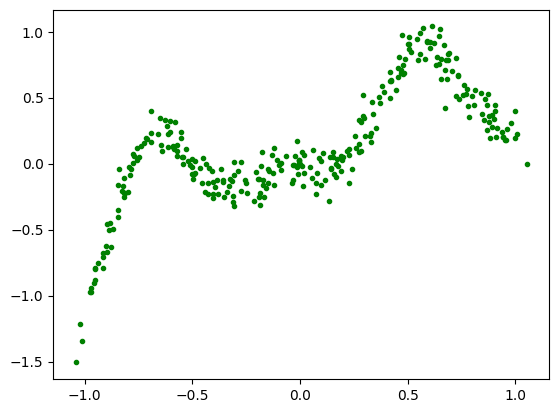

In [2]:
np.random.seed(12)
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = torch.Tensor(x.reshape(-1,1))
yy = torch.Tensor(y.reshape(-1,1))

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [3]:
class PICNN_Model(nn.Module):
    
    def __init__(self, convex=True, h=10):
        super().__init__()
        self.convex = convex
        
        ## for convex
        self.la0 = nn.Linear(1, h)
        self.la1 = nn.Linear(h, h)
        self.la2 = nn.Linear(h, h)
        
        self.xla1 = nn.Linear(1, h)
        self.xla2 = nn.Linear(1, h)
        
        ## for non-convex
        self.pla0 = nn.Linear(1, h)
        self.pla1 = nn.Linear(h, h)
        self.pla2 = nn.Linear(h, h)
        
        self._pla0 = nn.Linear(1, h)
        self._pla1 = nn.Linear(h, h)
        self._pla2 = nn.Linear(h, h)
        
        self.linear = nn.Linear(h, 1)
        self.plinear = nn.Linear(h, 1)
        self.xlinear = nn.Linear(1, 1)
        
        self.actf = nn.ELU()
#         self.actf = nn.Softplus()

        self._rescale_parameters_()
        
        
    def _rescale_parameters_(self):
        for p in self.parameters():
#             print(p.shape)
            p.data = p.data/2.
        
    ## convex in y, non-convex in x
    def forward(self, x, y):
        if self.convex:
            self.la1.weight.data.abs_()
            self.la2.weight.data.abs_()
            self.linear.weight.data.abs_()
            
        b = x.shape[0]
        
        u1 = self.actf(self.pla0(x))
        z1 = self.actf(self.la0(y) + self._pla0(x))
        
        u2 = self.actf(self.pla1(u1))
        z2 = self.actf(self.la1(z1) + self._pla1(u1) + self.xla1(x))
        
        u3 = self.actf(self.pla2(u2))
        z3 = self.actf(self.la2(z2) + self._pla2(u2) + self.xla2(x))
        
        z4 = self.linear(z3.reshape(b, -1)) + self.plinear(u3.reshape(b, -1)) + self.xlinear(x.reshape(b, -1))
        
        return z4

In [4]:
from nflib import flows, coupling_flows

In [5]:
class MLP_Generator(coupling_flows.FuncGenerator):

    def __init__(self, hidden_dims=[], activation=nn.ELU()):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.activation = activation

    def generate(self, input_dim, output_dim):
        dims = [input_dim, *self.hidden_dims]
        layers = []
        for i in range(len(dims)-1):
            a = nn.Linear(dims[i], dims[i+1])
            b = self.activation
            layers += [a, b]
        fl = nn.Linear(dims[-1], output_dim)
        fl.weight.data *= 0.
        layers.append(fl)
        return nn.Sequential(*layers)

In [6]:
class CouplingFlow(nn.Module):
    def __init__(self,func_generator):
        super().__init__()
        self.s_cond = func_generator.generate(1, 1)
        self.t_cond = func_generator.generate(1, 1)
        
    def forward(self, x, y):
        s = self.s_cond(x)
        t = self.t_cond(x)
        y = torch.exp(s) * y + t # transform this half as a function of the other
        return y

In [7]:
class PIINN_Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cfs = [CouplingFlow(MLP_Generator([10])) for _ in range(10)]
        self.cfs = nn.ModuleList(self.cfs)
        self.pconvex = PICNN_Model()
        
    def forward(self,x,y):
        for cf in self.cfs:
            y = cf(x, y)
        e = self.pconvex(x, y)
        return e

In [8]:
device = torch.device("cuda:0")

In [28]:
model = PICNN_Model()
# model = PIINN_Model()

model = model.to(device)

In [29]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

784

### Training Setup

In [30]:
initial_Y = yy.mean(dim=0)
initial_Y

tensor([0.1313], device='cuda:0')

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
# criterion = nn.BCELoss()
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

In [32]:
inner_lr = 0.01
inner_momentum = 0.9
inner_steps = 30

STEPS = 4000

### Training Loop

STEPS: 0, Train Error: 0.8120123147964478


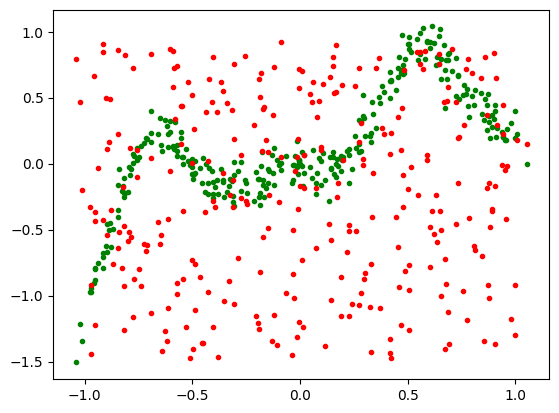

STEPS: 200, Train Error: 0.5434406399726868


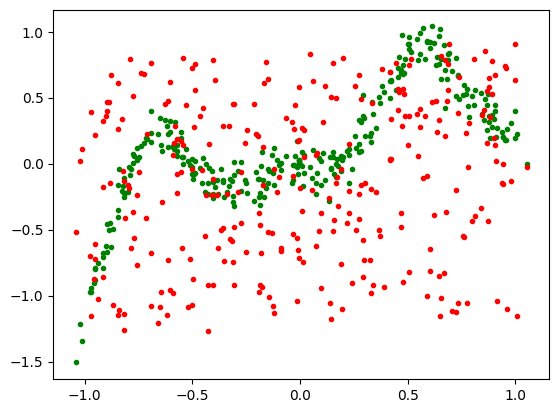

STEPS: 400, Train Error: 0.07673903554677963


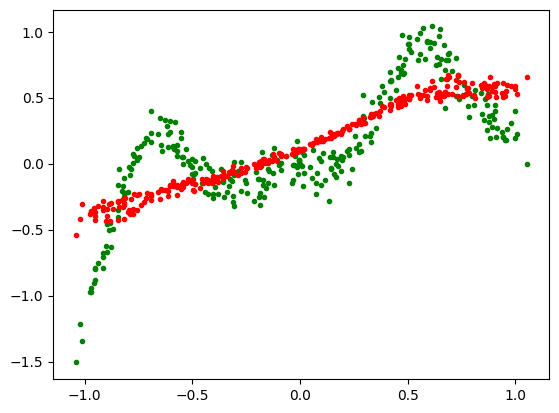

STEPS: 600, Train Error: 0.05416258051991463


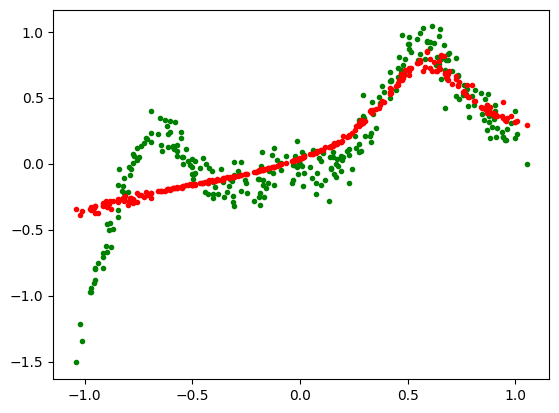

STEPS: 800, Train Error: 0.04901368170976639


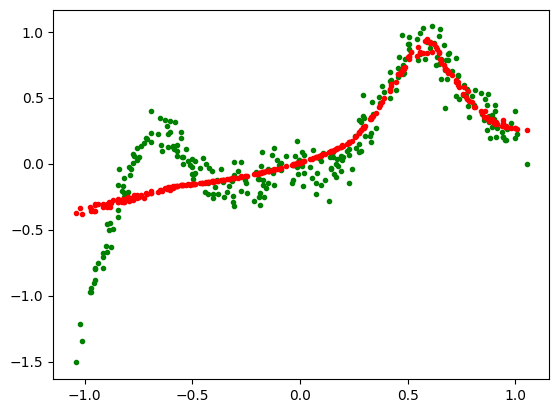

STEPS: 1000, Train Error: 0.04752403870224953


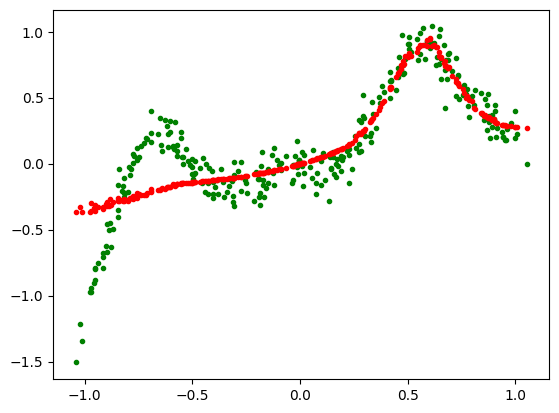

STEPS: 1200, Train Error: 0.04560621827840805


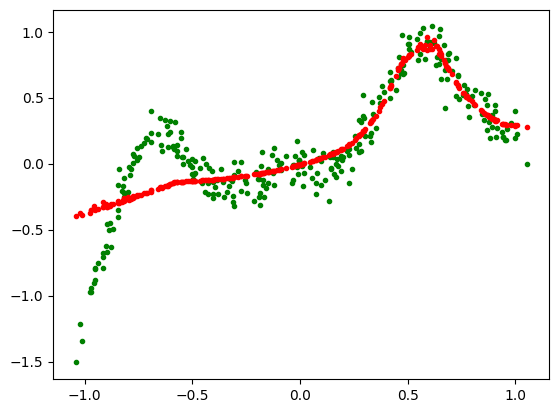

STEPS: 1400, Train Error: 0.04129711166024208


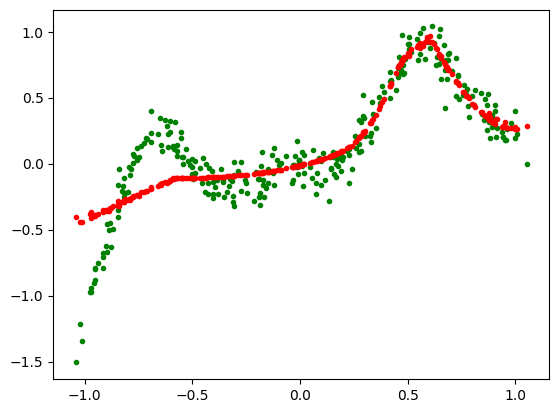

STEPS: 1600, Train Error: 0.030264893546700478


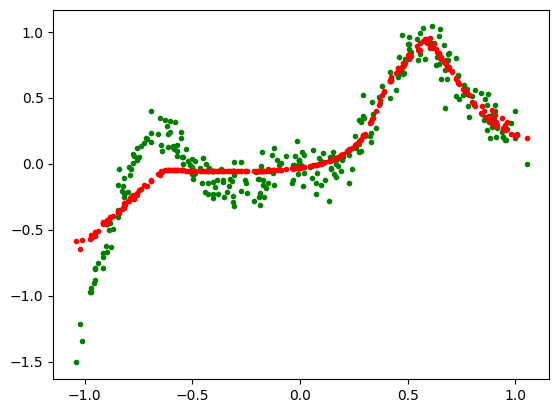

STEPS: 1800, Train Error: 0.017900865525007248


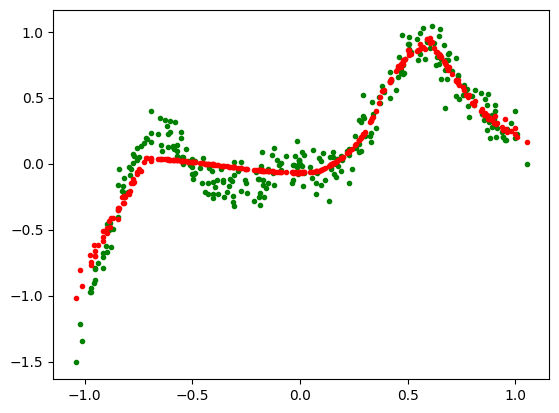

STEPS: 2000, Train Error: 0.014361655339598656


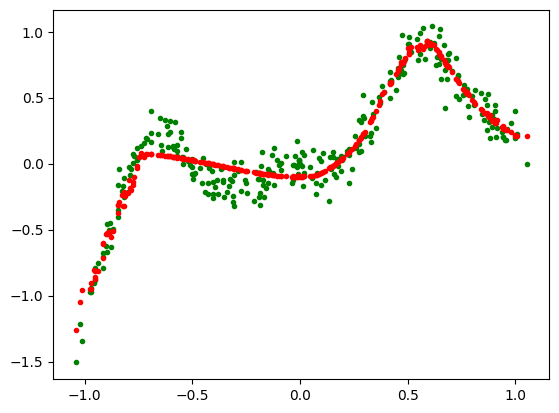

STEPS: 2200, Train Error: 0.0127653693780303


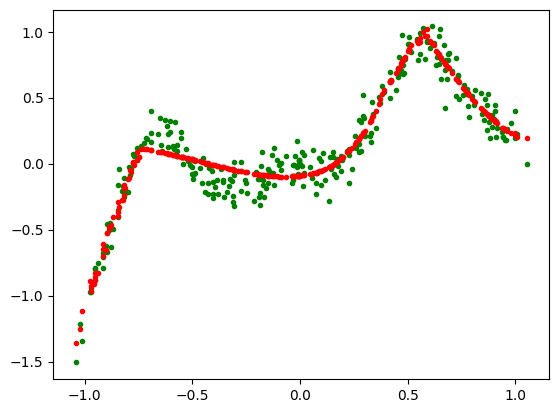

STEPS: 2400, Train Error: 0.012076647952198982


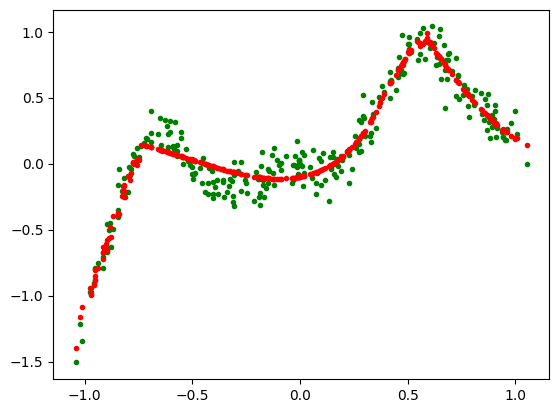

STEPS: 2600, Train Error: 0.011713502928614616


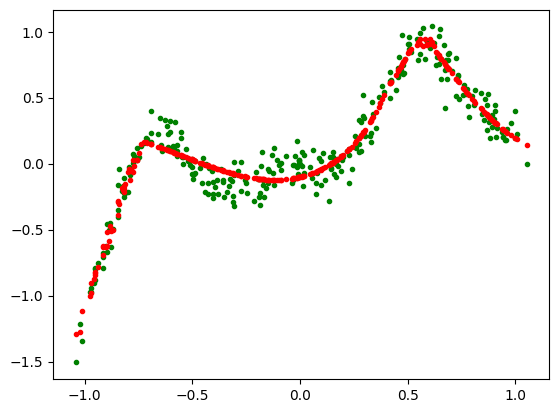

STEPS: 2800, Train Error: 0.011332761496305466


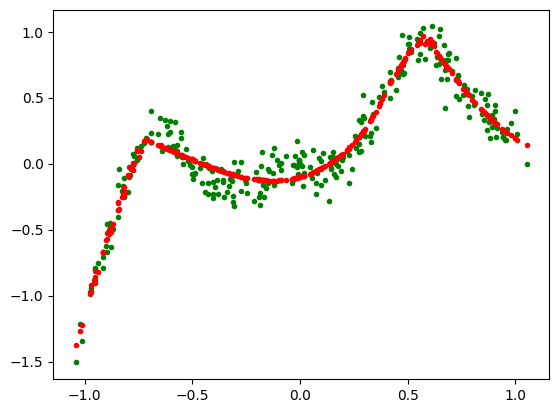

STEPS: 3000, Train Error: 0.011262643150985241


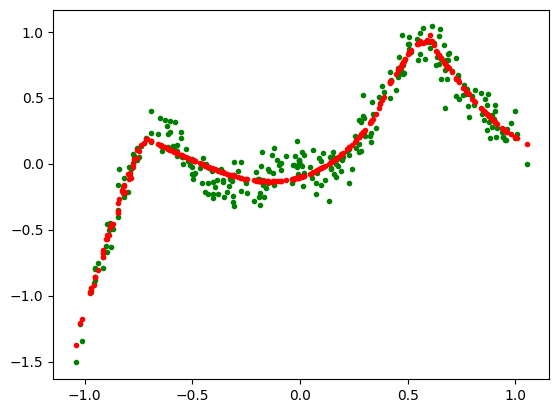

STEPS: 3200, Train Error: 0.01123463548719883


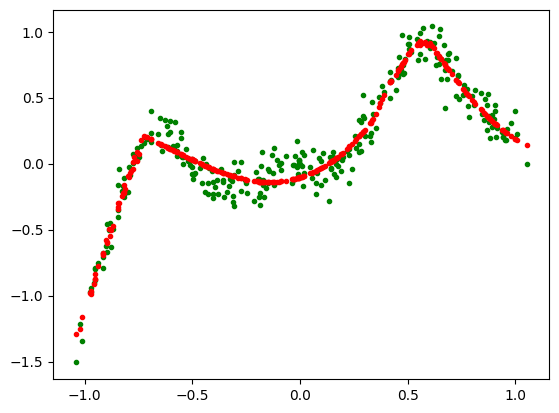

STEPS: 3400, Train Error: 0.010976714082062244


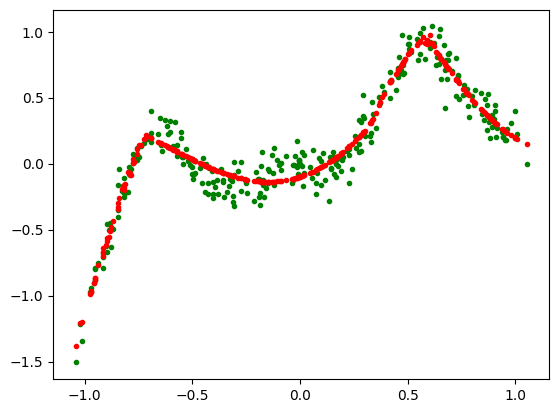

KeyboardInterrupt: 

In [33]:
xx, yy = xx.to(device), yy.to(device)
model = model.to(device)
for step in range(STEPS):
    optimizer.zero_grad() 

#     yi = initial_Y.expand_as(yy).to(device)
    yi = torch.rand(yy.shape).to(device)*2.5-1.5
    yi = torch.autograd.Variable(yi, requires_grad=True)

    Ei = model(xx, yi)
    vi = 0.
    for i in range(inner_steps):
        prev_vi = vi
        grad = torch.autograd.grad(outputs=Ei, inputs=yi, grad_outputs=torch.ones_like(Ei), 
                                only_inputs=True, retain_graph=True, create_graph=True)[0]

        if step < 200:
            vi = inner_momentum*prev_vi - inner_lr*grad
            yi = yi - inner_momentum*prev_vi + (1+inner_momentum)*vi
        yi = yi - inner_lr*grad

        Ei = model(xx, yi)


    error = criterion(yi, yy)
    error.backward()
    optimizer.step()
    
    if step%200 == 0:
        print(f"STEPS: {step}, Train Error: {float(error)}")

        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(x, yi.data.cpu().reshape(-1), marker='.', color='r')
        plt.show()

In [34]:
step, error.item()

(3413, 0.01103983074426651)

### Visualize every step of GD

STEPS: 0, Train Error: 0.8613276481628418, Energy: 117.96495056152344


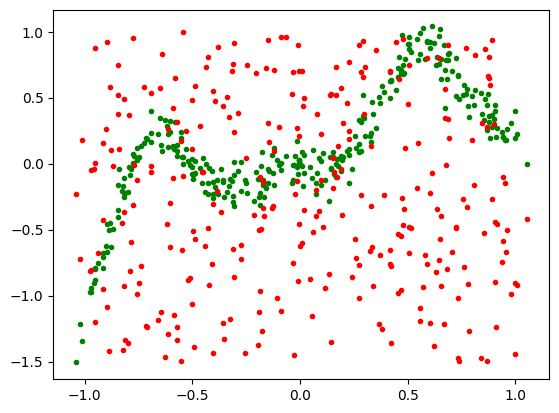

STEPS: 1, Train Error: 0.5144752264022827, Energy: 113.36705780029297


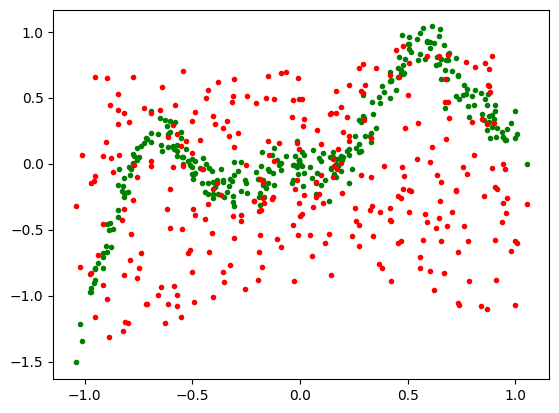

STEPS: 2, Train Error: 0.3153057396411896, Energy: 110.79393768310547


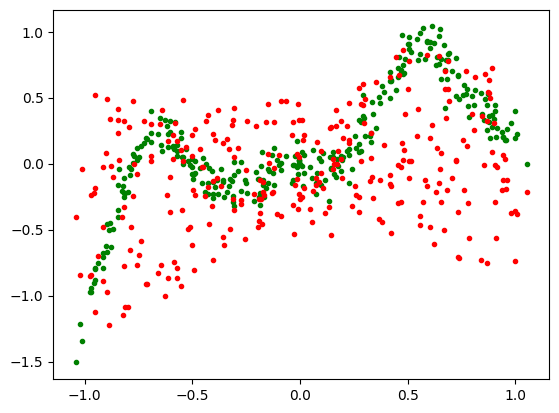

STEPS: 3, Train Error: 0.1986655294895172, Energy: 109.31455993652344


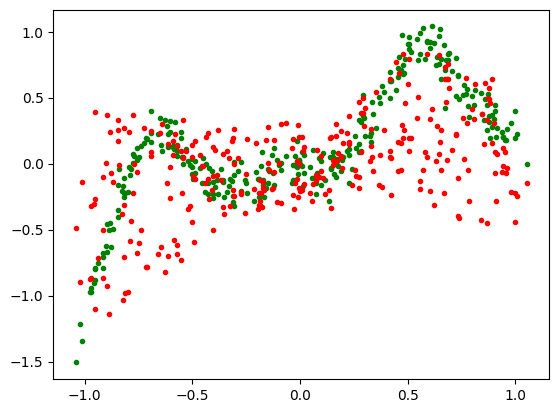

STEPS: 4, Train Error: 0.12973926961421967, Energy: 108.45487213134766


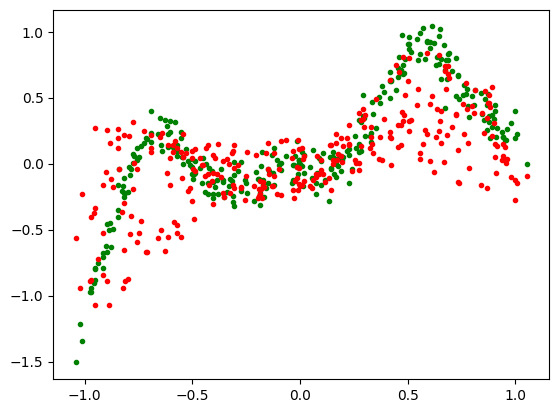

STEPS: 5, Train Error: 0.08845064789056778, Energy: 107.95446014404297


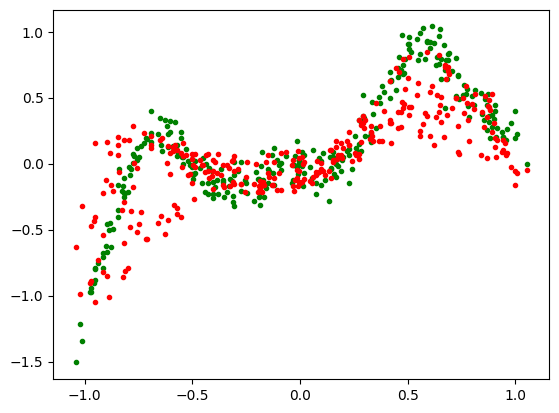

STEPS: 6, Train Error: 0.06357283890247345, Energy: 107.67635345458984


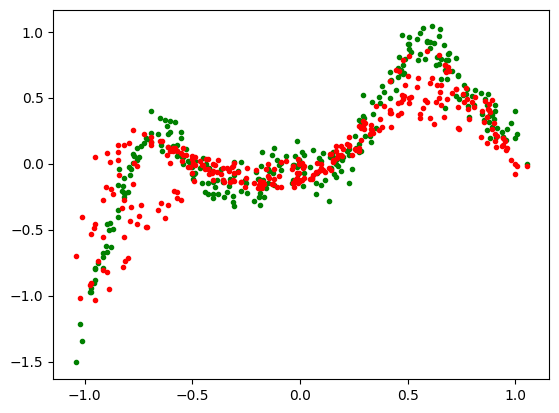

STEPS: 7, Train Error: 0.0479511134326458, Energy: 107.51608276367188


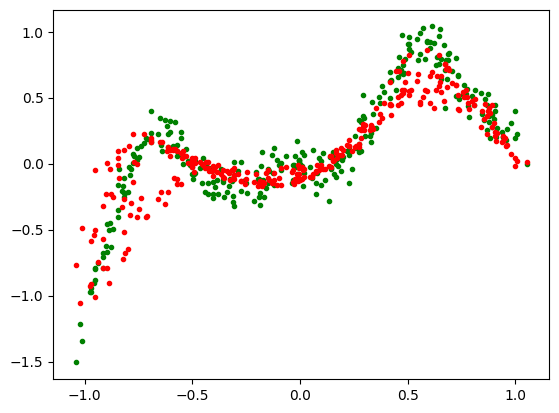

STEPS: 8, Train Error: 0.037750244140625, Energy: 107.42085266113281


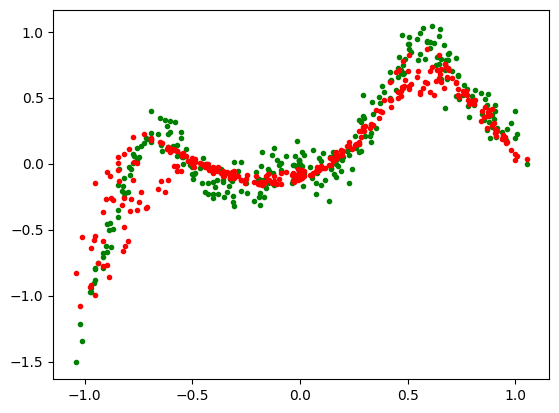

STEPS: 9, Train Error: 0.030879586935043335, Energy: 107.36427307128906


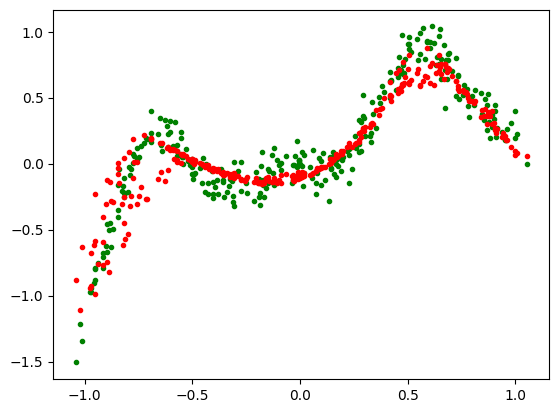

STEPS: 10, Train Error: 0.025995023548603058, Energy: 107.32720184326172


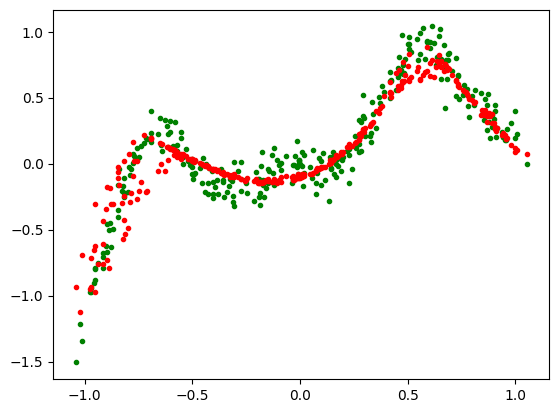

STEPS: 11, Train Error: 0.0224373210221529, Energy: 107.30194091796875


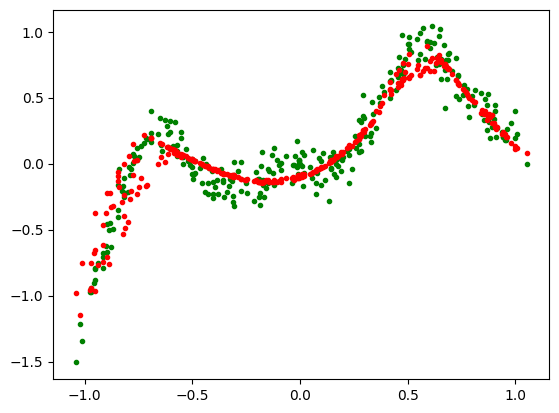

STEPS: 12, Train Error: 0.019770890474319458, Energy: 107.28414154052734


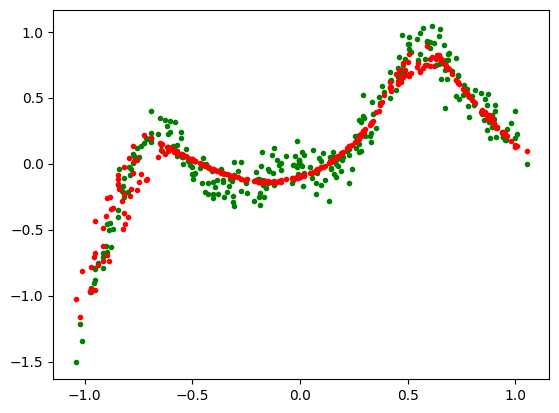

STEPS: 13, Train Error: 0.01777731627225876, Energy: 107.27163696289062


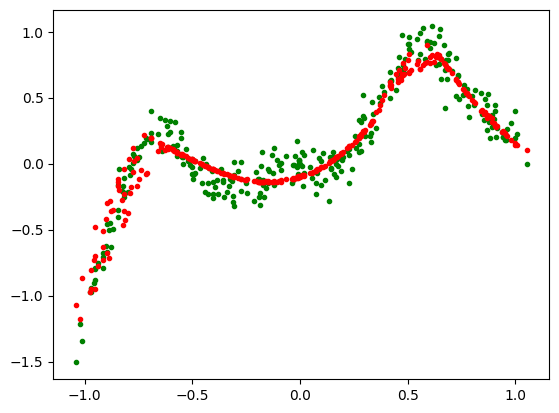

STEPS: 14, Train Error: 0.016263285651803017, Energy: 107.26241302490234


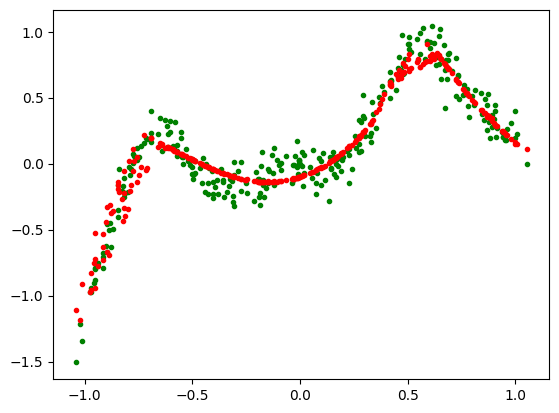

STEPS: 15, Train Error: 0.015095545910298824, Energy: 107.25541687011719


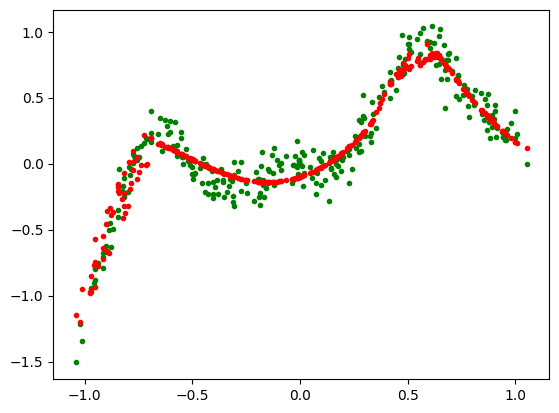

STEPS: 16, Train Error: 0.014188680797815323, Energy: 107.25001525878906


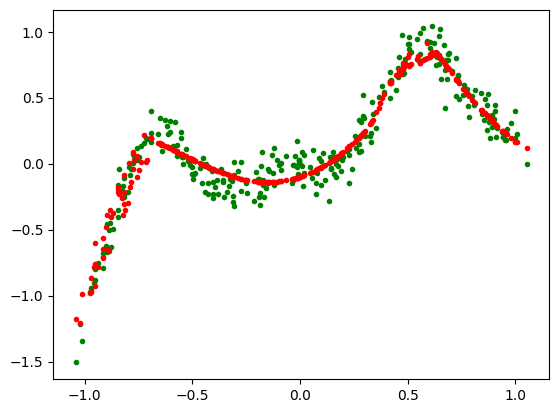

STEPS: 17, Train Error: 0.013480644673109055, Energy: 107.2458267211914


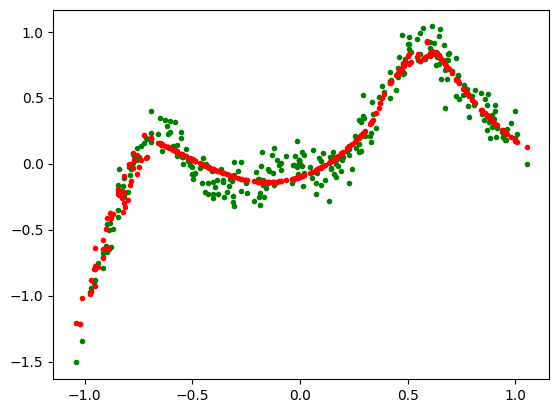

STEPS: 18, Train Error: 0.012924307957291603, Energy: 107.24253845214844


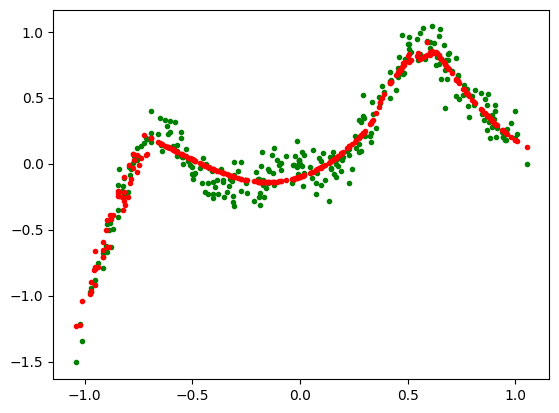

STEPS: 19, Train Error: 0.01248699426651001, Energy: 107.23993682861328


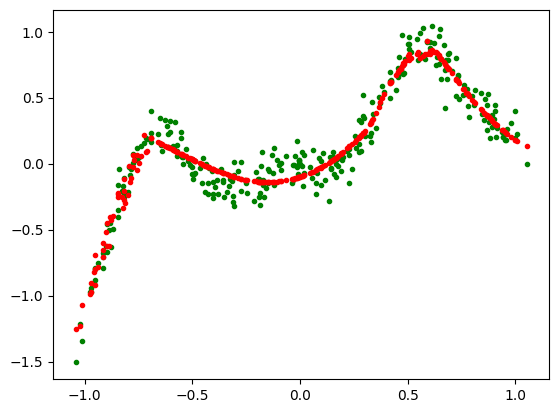

STEPS: 20, Train Error: 0.012145212851464748, Energy: 107.23788452148438


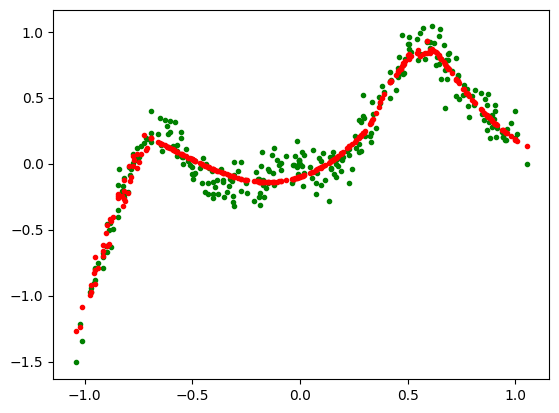

STEPS: 21, Train Error: 0.01187832374125719, Energy: 107.23628234863281


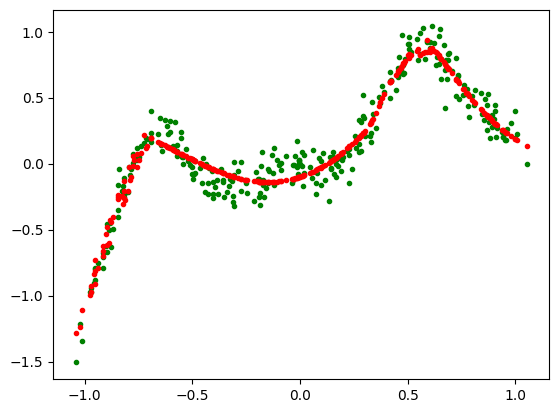

STEPS: 22, Train Error: 0.01166968047618866, Energy: 107.23500061035156


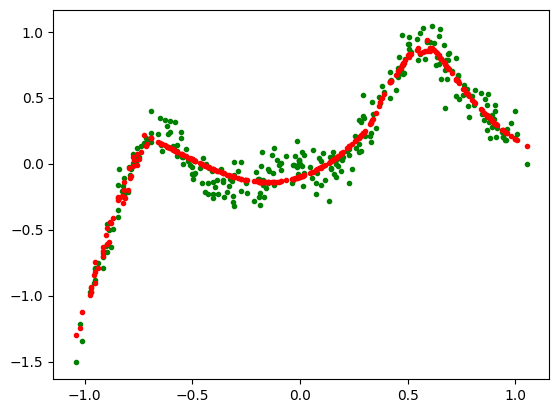

STEPS: 23, Train Error: 0.011505543254315853, Energy: 107.2339859008789


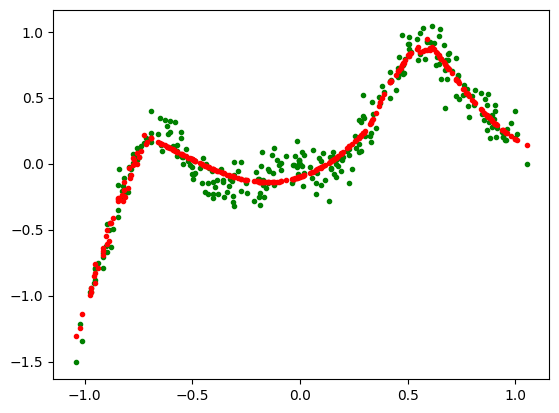

STEPS: 24, Train Error: 0.011377041228115559, Energy: 107.2331771850586


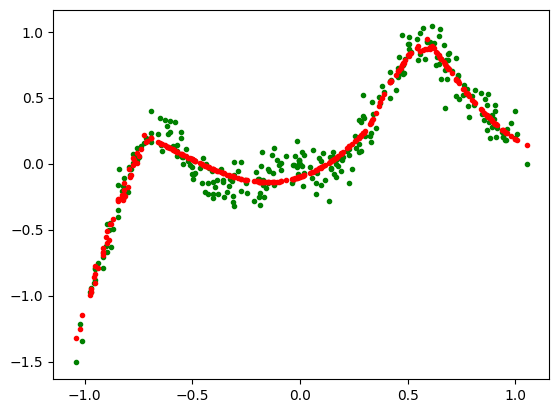

STEPS: 25, Train Error: 0.011276820674538612, Energy: 107.23252868652344


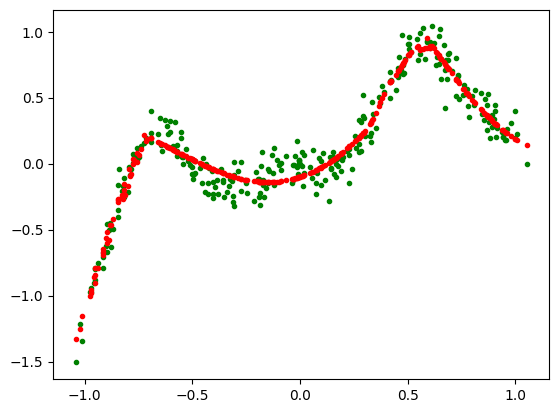

STEPS: 26, Train Error: 0.011198925785720348, Energy: 107.23199462890625


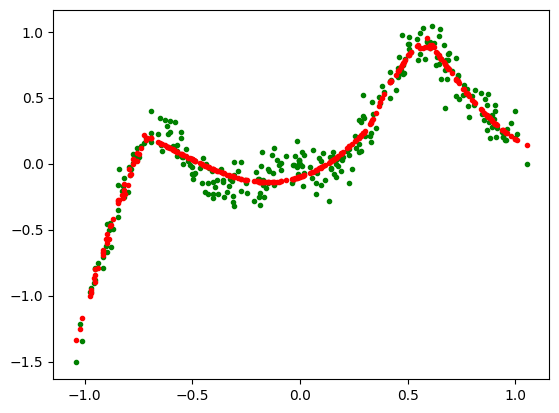

STEPS: 27, Train Error: 0.011138676665723324, Energy: 107.23157501220703


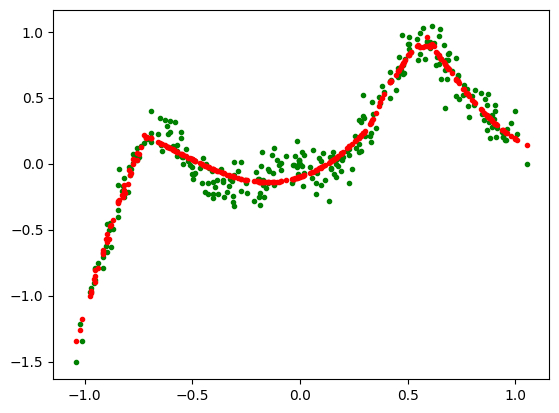

STEPS: 28, Train Error: 0.011092147789895535, Energy: 107.23123931884766


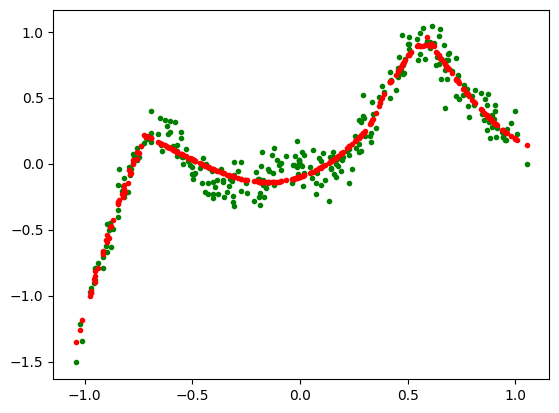

STEPS: 29, Train Error: 0.011056717485189438, Energy: 107.2309799194336


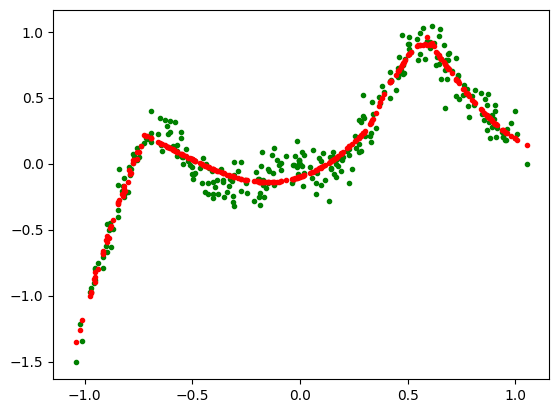

STEPS: 30, Train Error: 0.01103048026561737, Energy: 107.23077392578125


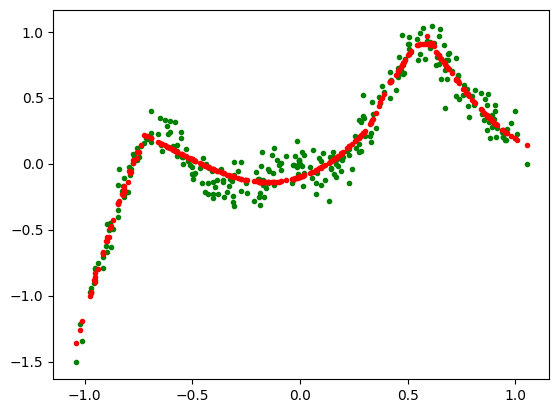

STEPS: 31, Train Error: 0.01101066917181015, Energy: 107.23060607910156


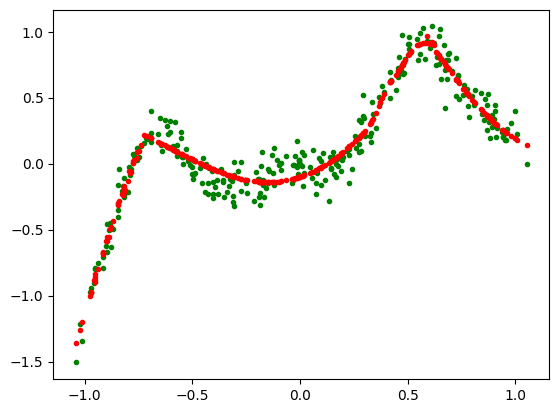

STEPS: 32, Train Error: 0.010995875112712383, Energy: 107.23047637939453


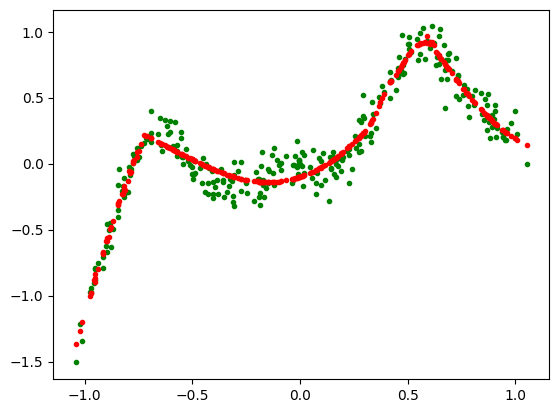

STEPS: 33, Train Error: 0.010985063388943672, Energy: 107.23037719726562


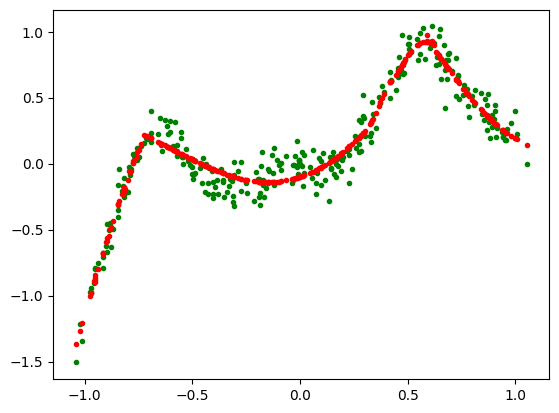

STEPS: 34, Train Error: 0.010977884754538536, Energy: 107.23028564453125


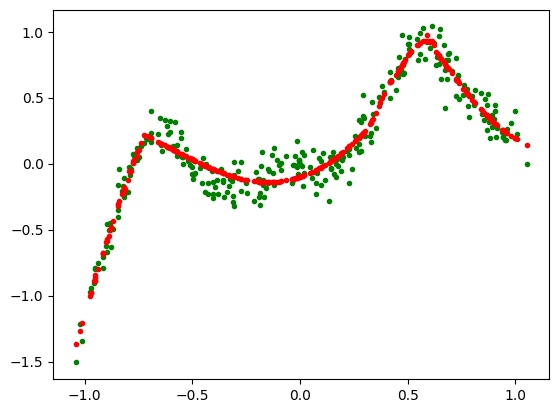

STEPS: 35, Train Error: 0.010973828844726086, Energy: 107.230224609375


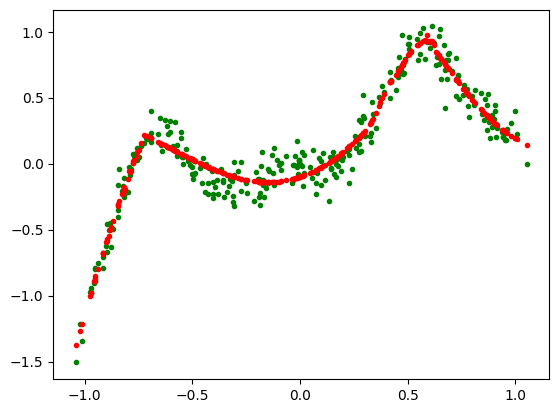

STEPS: 36, Train Error: 0.010972538962960243, Energy: 107.23016357421875


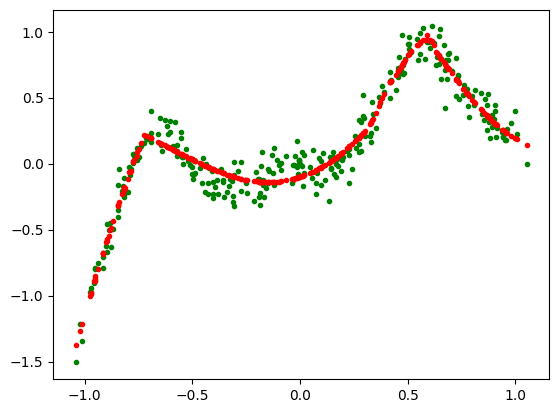

STEPS: 37, Train Error: 0.010973355732858181, Energy: 107.23011016845703


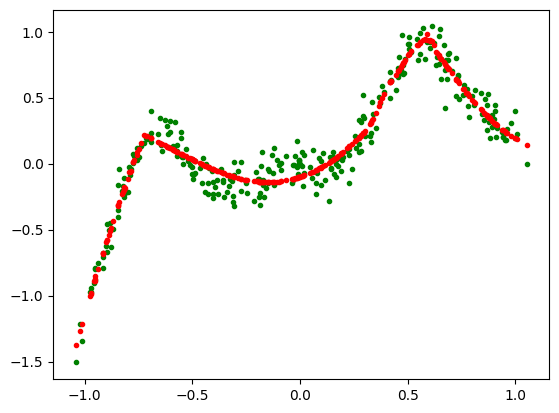

STEPS: 38, Train Error: 0.010975695215165615, Energy: 107.2300796508789


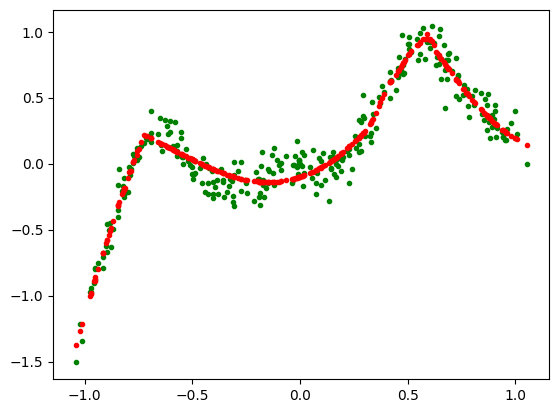

STEPS: 39, Train Error: 0.010978597216308117, Energy: 107.23004913330078


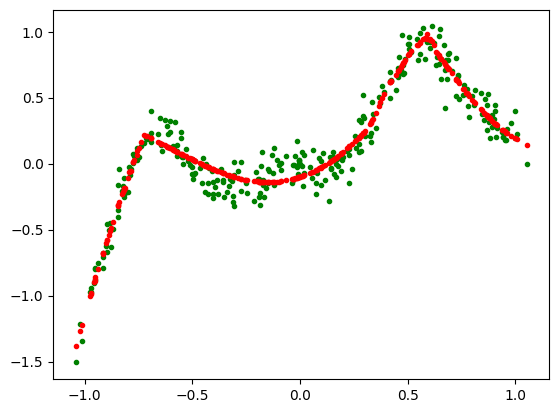

STEPS: 40, Train Error: 0.010981482453644276, Energy: 107.23002624511719


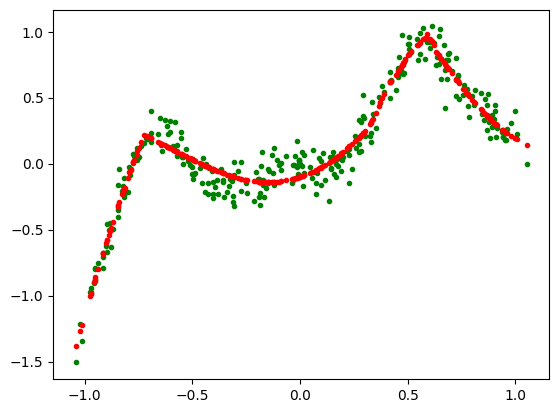

STEPS: 41, Train Error: 0.010984355583786964, Energy: 107.23001098632812


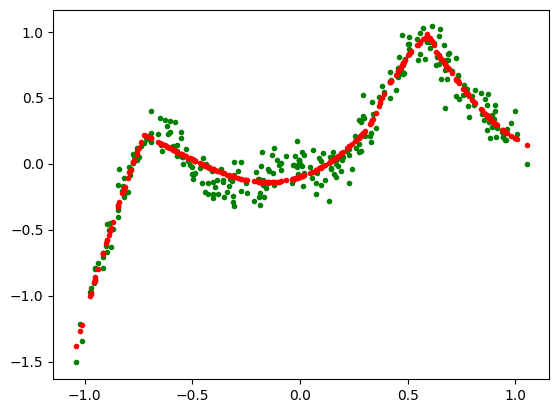

STEPS: 42, Train Error: 0.010987226851284504, Energy: 107.22998809814453


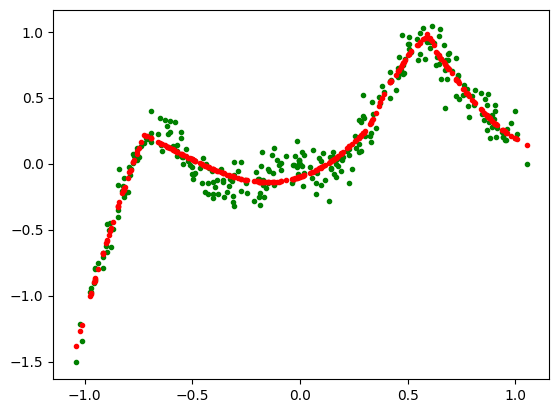

STEPS: 43, Train Error: 0.010990103706717491, Energy: 107.22997283935547


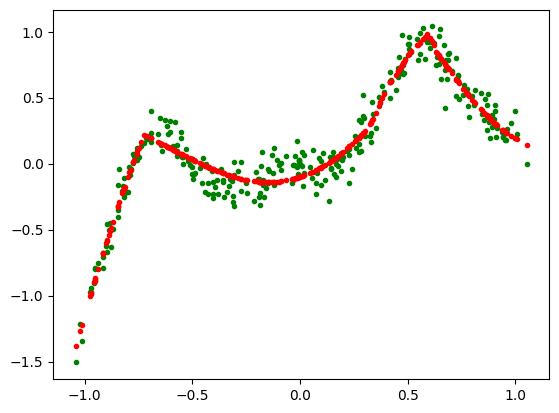

STEPS: 44, Train Error: 0.010992985218763351, Energy: 107.22996520996094


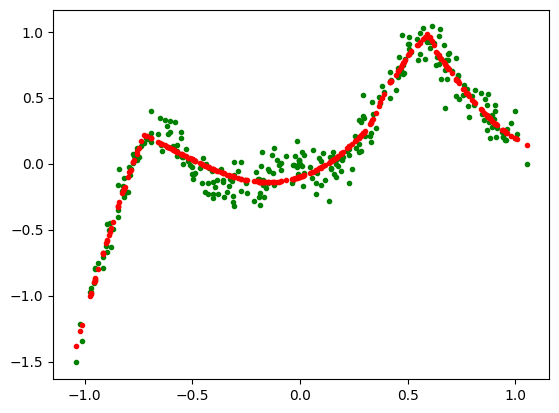

STEPS: 45, Train Error: 0.010995869524776936, Energy: 107.22994995117188


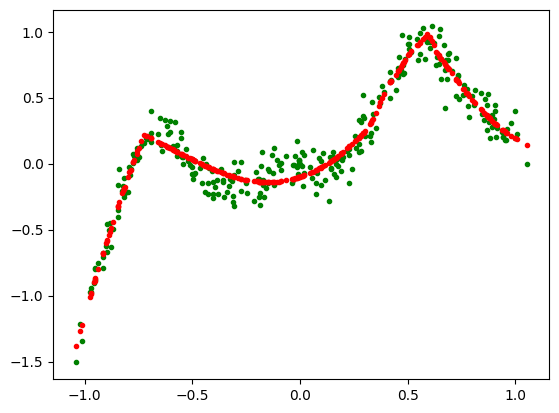

STEPS: 46, Train Error: 0.010998752899467945, Energy: 107.22994232177734


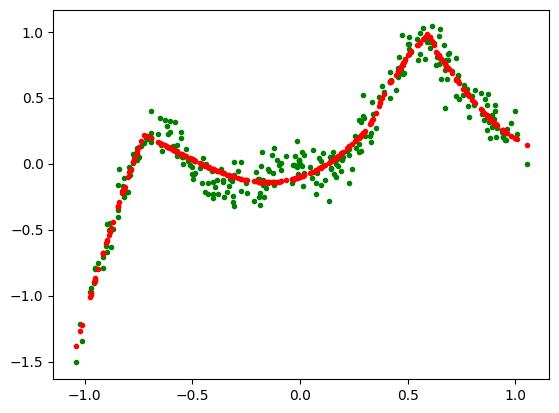

STEPS: 47, Train Error: 0.011001629754900932, Energy: 107.22993469238281


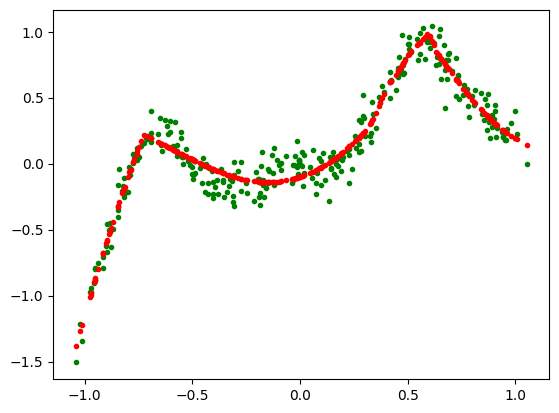

STEPS: 48, Train Error: 0.01100432500243187, Energy: 107.22993469238281


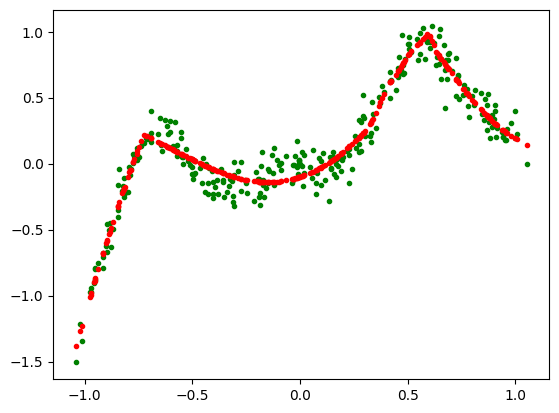

STEPS: 49, Train Error: 0.011006811633706093, Energy: 107.22993469238281


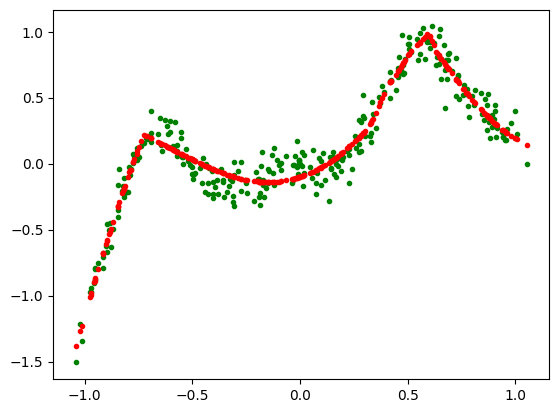

STEPS: 50, Train Error: 0.011008732952177525, Energy: 107.22992706298828


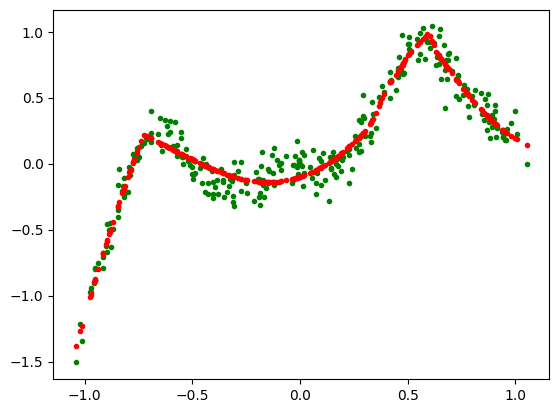

In [35]:
optimizer.zero_grad() 
model = model.to(device)

# yi = initial_Y.expand_as(yy).to(device)
yi = torch.rand(yy.shape).to(device)*2.5-1.5
yi = torch.autograd.Variable(yi, requires_grad=True)

Ei = model(xx, yi)
vi = 0.
error = criterion(yi, yy)

print(f"STEPS: {0}, Train Error: {float(error)}, Energy: {float(Ei.mean())}")
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yi.data.cpu().reshape(-1), marker='.', color='r')
plt.show()

## infer for more steps than trained for
for i in range(inner_steps+20):
    prev_vi = vi
    grad = torch.autograd.grad(outputs=Ei, inputs=yi, grad_outputs=torch.ones_like(Ei), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]

    ### infer with momentum
#     vi = inner_momentum*prev_vi - inner_lr*grad
#     yi = yi - inner_momentum*prev_vi + (1+inner_momentum)*vi
    
    ## infer without momentum
    yi = yi - inner_lr*grad
    
    Ei = model(xx, yi)

    error = criterion(yi, yy)

    print(f"STEPS: {i+1}, Train Error: {float(error)}, Energy: {float(Ei.mean())}")
    plt.scatter(x, y, marker='.', color='g')
    plt.scatter(x, yi.data.cpu().reshape(-1), marker='.', color='r')
    plt.show()

### Visualize the surface of loss

In [44]:
## GRID to visualize partial convex landscape 
num_points = 200
X1 = np.linspace(-1.2, 1.2, num_points)
X2 = np.linspace(-1.6, 1.1, num_points+10)
X1, X2 = np.meshgrid(X1, X2)

In [45]:
model = model.cpu()
E12 = model(torch.Tensor(X1.reshape(-1,1)), torch.Tensor(X2.reshape(-1,1)))
E12 = E12.data.numpy().reshape(X1.shape)

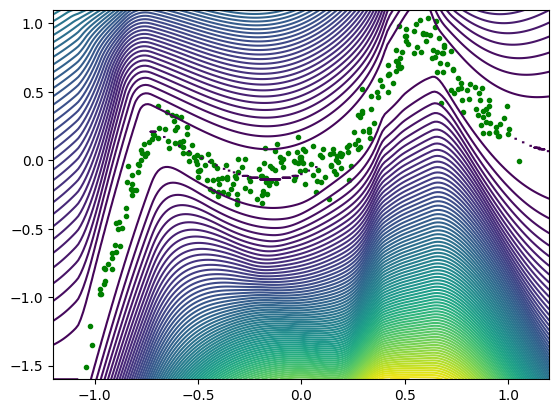

In [46]:
plt.contour(X1, X2, E12-E12.min(0, keepdims=True), levels=100)
# plt.contour(X1, X2, E12, levels=100)
plt.scatter(x, y, marker='.', color='g')
if isinstance(model, PICNN_Model):
    plt.savefig("./invex_out/pcnn_2d_surface.pdf")
elif isinstance(model, PIINN_Model):
    plt.savefig("./invex_out/pinn_2d_surface.pdf")

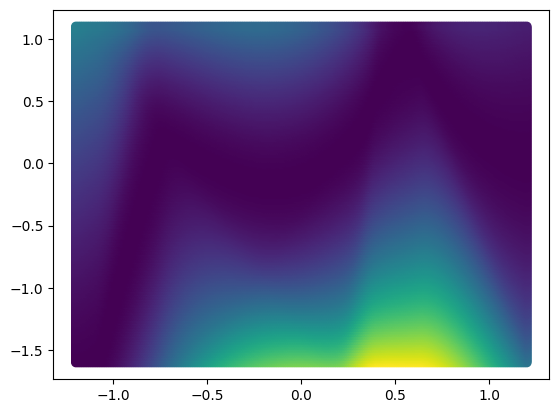

In [47]:
plt.scatter(X1, X2, c=E12-E12.min(0, keepdims=True))

In [22]:
minimas = E12.argmin(0)
minimas.shape

(50,)

In [23]:
X1.shape, X2.shape

((60, 50), (60, 50))

In [24]:
### Minimas from the grid data
xmin, ymin = [], []
for i, m in enumerate(minimas):
    xmin.append(X1[m,i])
    ymin.append(X2[m,i])

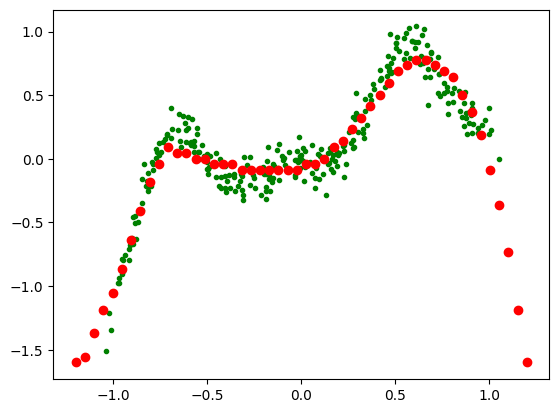

In [25]:
plt.scatter(x, y, marker='.', color='g')
plt.scatter(xmin, ymin, color='r')